# English-to-German Translation with a Sequence-to-Sequence Transformer

**Author:** Deeepwin, [fchollet](https://twitter.com/fchollet) <br>
**Date created:** 2021/05/26<br>
**Last modified:** 2022/11/05<br>
**Description:** Implementing a sequence-to-sequene Transformer and training it on a machine translation task.
***

## Introduction

In this example, we'll build a sequence-to-sequence Transformer model, which
we'll train on an English-to-German machine translation task.

You'll learn how to:

- Vectorize text using the Keras `TextVectorization` layer.
- Implement a `TransformerEncoder` layer, a `TransformerDecoder` layer,
and a `PositionalEmbedding` layer.
- Prepare data for training a sequence-to-sequence model.
- Use the trained model to generate translations of never-seen-before
input sentences (sequence-to-sequence inference).

The code featured here is adapted from the book
[Deep Learning with Python, Second Edition](https://www.manning.com/books/deep-learning-with-python-second-edition)
(chapter 11: Deep learning for text).
The present example is fairly barebones, so for detailed explanations of
how each building block works, as well as the theory behind Transformers,
I recommend reading the book.

## Setup

In [1]:
import pathlib
import random
import string
import re
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers import TextVectorization
from deep_translator import GoogleTranslator

In [2]:
np.set_printoptions(linewidth=160)

# Configuration

In [3]:
num_heads       = 8

dense_dim       = (3* 2048)     # Dimension of feed forward fully connected layers
embed_dim       = 256           # Dimension of model output layers

vocab_size      = 15000         # Vocabulary size
sequence_length = 20            # Maximum length of the input sequence

batch_size      = 32

## Downloading the data

We'll be working with an English-to-GErman translation dataset
provided by [Anki](https://www.manythings.org/anki/). Let's download it:

In [4]:
import requests
import os
from zipfile import ZipFile
from pathlib import Path

zip_file   = 'deu-eng.zip'

my_file = Path(zip_file)
if not my_file.is_file():

    url         = 'https://www.manythings.org/anki/' + zip_file
    headers     = {'User-Agent': 'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_10_1) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/39.0.2171.95 Safari/537.36'}

    r = requests.get(url, headers=headers)

    open(os.path.join('data', zip_file), 'wb').write(r.content)

    deu_eng_zip = ZipFile(os.path.join('data', zip_file), 'r')
    deu_eng_zip.extract("deu.txt")

'/home/martin/GitHub/transformers/deu.txt'

## Parsing the data

Each line contains an English sentence and its corresponding German sentence.
The English sentence is the *source sequence* and German one is the *target sequence*.
We prepend the token `"[start]"` and we append the token `"[end]"` to the German sentence.

In [5]:
with open("deu.txt") as f:
    lines = f.read().split("\n")[:-1]
text_pairs = []
for line in lines:
    eng, deu, _ = line.split("\t")
    deu = "[start] " + deu + " [end]"
    text_pairs.append((eng, deu))

Here's what our sentence pairs look like:

In [6]:
for _ in range(5):
    print(random.choice(text_pairs))

('Why did you kiss me?', '[start] Warum hast du mich geküsst? [end]')
("Tom told Mary that he thought John wasn't the first one to do that.", '[start] Tom meinte zu Maria, Johannes habe das nicht als erster getan. [end]')
('Tom never was generous.', '[start] Tom war nie großzügig. [end]')
('My father gave me a puppy for my birthday.', '[start] Mein Vater hat mir zum Geburtstag ein kleines Hündchen geschenkt. [end]')
('Last century they would have just thrown someone like Tom into a lunatic asylum.', '[start] Im letzten Jahrhundert wäre jemand wie Tom schlichtweg ins Irrenhaus gesteckt worden. [end]')


Now, let's split the sentence pairs into a training set, a validation set,
and a test set.

In [7]:
random.shuffle(text_pairs)

num_val_samples     = int(0.15 * len(text_pairs))
num_train_samples   = len(text_pairs) - 2 * num_val_samples


train_pairs     = text_pairs[:num_train_samples]
val_pairs       = text_pairs[num_train_samples : num_train_samples + num_val_samples]
test_pairs      = text_pairs[num_train_samples + num_val_samples :]

print(f"{len(text_pairs)} total pairs")
print(f"{len(train_pairs)} training pairs")
print(f"{len(val_pairs)} validation pairs")
print(f"{len(test_pairs)} test pairs")

255817 total pairs
179073 training pairs
38372 validation pairs
38372 test pairs


## Vectorizing the text data

We'll use two instances of the `TextVectorization` layer to vectorize the text
data (one for English and one for German),
that is to say,   

      to turn the original strings into integer sequences where each integer represents the index of a word in a vocabulary.

Note: in a production-grade machine translation model, I would not recommend stripping the punctuation characters in either language. Instead, I would recommend turning
each punctuation character into its own token, which you could achieve by providing a custom `split` function to the `TextVectorization` layer.

In [8]:
strip_chars = string.punctuation
strip_chars = strip_chars.replace("[", "")
strip_chars = strip_chars.replace("]", "")

def custom_standardization(input_string):
    lowercase = tf.strings.lower(input_string)
    return tf.strings.regex_replace(lowercase, "[%s]" % re.escape(strip_chars), "")


eng_vectorization = TextVectorization(  max_tokens=vocab_size, 
                                        output_mode="int", 
                                        output_sequence_length=sequence_length)

deu_vectorization = TextVectorization(  max_tokens=vocab_size,
                                        output_mode="int",
                                        output_sequence_length=sequence_length + 1,
                                        standardize=custom_standardization)
                                        
train_eng_texts = [pair[0] for pair in train_pairs]
train_deu_texts = [pair[1] for pair in train_pairs]
eng_vectorization.adapt(train_eng_texts);
deu_vectorization.adapt(train_deu_texts);

2022-11-05 16:55:03.942816: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-05 16:55:03.943533: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-05 16:55:03.950398: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-05 16:55:03.951414: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-05 16:55:03.951865: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from S

Next, we'll format our datasets.

At each training step, the model will seek to predict target words N+1 (and beyond)
using the source sentence and the target words 0 to N.

As such, the training dataset will yield a tuple `(inputs, targets)`, where:

- `inputs` is a dictionary with the keys `encoder_inputs` and `decoder_inputs`.   
   
  `encoder_inputs` is the vectorized source sentence and   
  `encoder_inputs` is the target sentence "so far",
that is to say, the words 0 to N used to predict word N+1 (and beyond) in the target sentence.
- `target` is the target sentence offset by one step:
it provides the next words in the target sentence -- what the model will try to predict.

In [9]:

def format_dataset(eng, deu):
    eng = eng_vectorization(eng)
    deu = deu_vectorization(deu)
    return ({"encoder_inputs": eng, "decoder_inputs": deu[:, :-1],}, deu[:, 1:])


def make_dataset(pairs):
    eng_texts, deu_texts = zip(*pairs)
    eng_texts = list(eng_texts) # list with 83276 english sentences
    deu_texts = list(deu_texts) # same but in German
    dataset = tf.data.Dataset.from_tensor_slices((eng_texts, deu_texts))
    dataset = dataset.batch(batch_size)
    dataset = dataset.map(format_dataset)
    return dataset

train_ds = make_dataset(train_pairs)
val_ds = make_dataset(val_pairs)

Let's take a quick look at the sequence shapes
(we have batches of 64 pairs, and all sequences are 20 steps long):

In [10]:
for inputs, targets in train_ds.take(1):
    print(f'inputs["encoder_inputs"].shape: {inputs["encoder_inputs"].shape}')
    print(f'inputs["decoder_inputs"].shape: {inputs["decoder_inputs"].shape}')
    print(f"targets.shape: {targets.shape}")

inputs["encoder_inputs"].shape: (32, 20)
inputs["decoder_inputs"].shape: (32, 20)
targets.shape: (32, 20)


Let's have a more detailed look on first batch:

In [11]:
eng, deu = train_pairs[0]

print(eng)
print('                ', eng_vectorization(eng).numpy())
print(deu)
print('                ', deu_vectorization(deu).numpy())
print('---')
print('encoder_inputs: ', inputs["encoder_inputs"][0,:].numpy())
print('decoder_inputs: ', inputs["decoder_inputs"][0,:].numpy())
print('targets:        ', targets[0,:].numpy())


We want candy.
                 [  25   35 1962    0    0    0    0    0    0    0    0    0    0    0    0    0    0    0    0    0]
[start] Wir wollen etwas Süßes. [end]
                 [   2   20  198   59 3319    3    0    0    0    0    0    0    0    0    0    0    0    0    0    0    0]
---
encoder_inputs:  [  25   35 1962    0    0    0    0    0    0    0    0    0    0    0    0    0    0    0    0    0]
decoder_inputs:  [   2   20  198   59 3319    3    0    0    0    0    0    0    0    0    0    0    0    0    0    0]
targets:         [  20  198   59 3319    3    0    0    0    0    0    0    0    0    0    0    0    0    0    0    0]


Shuffle dataset now.

In [12]:
train_ds = train_ds.shuffle(2048).prefetch(16).cache()
val_ds = val_ds.shuffle(2048).prefetch(16).cache()

## Building the model

Our sequence-to-sequence Transformer consists of a `TransformerEncoder`
and a `TransformerDecoder` chained together. To make the model aware of word order,
we also use a `PositionalEmbedding` layer.  

The source sequence will be pass to the `TransformerEncoder`,
which will produce a new representation of it.
This new representation will then be passed
to the `TransformerDecoder`, together with the target sequence so far (target words 0 to N).
The `TransformerDecoder` will then seek to predict the next words in the target sequence (N+1 and beyond).

A key detail that makes this possible is causal masking
(see method `get_causal_attention_mask()` on the `TransformerDecoder`).
The `TransformerDecoder` sees the entire sequences at once, and thus we must make
sure that it only uses information from target tokens 0 to N when predicting token N+1
(otherwise, it could use information from the future, which would
result in a model that cannot be used at inference time).

In [13]:

class TransformerEncoder(layers.Layer):

    def __init__(self, embed_dim, dense_dim, num_heads, **kwargs):
    
        super(TransformerEncoder, self).__init__(**kwargs)

        self.embed_dim = embed_dim  
        self.dense_dim = dense_dim
        self.num_heads = num_heads

        self.attention = layers.MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)
        
        self.dense_proj = keras.Sequential( [   layers.Dense(dense_dim, activation="relu"),
                                                layers.Dense(embed_dim),
                                            ])
        
        self.layernorm_1 = layers.LayerNormalization()
        self.layernorm_2 = layers.LayerNormalization()

        self.supports_masking = True

    def call(self, inputs, mask=None):  # inputs = [64 20 256]

        if mask is not None:
            padding_mask = tf.cast(mask[:, tf.newaxis, tf.newaxis, :], dtype="int32")

        attention_output = self.attention(  query=inputs, 
                                            value=inputs, 
                                            key=inputs, 
                                            attention_mask=padding_mask)

        proj_input = self.layernorm_1(inputs + attention_output)
        proj_output = self.dense_proj(proj_input)

        out = self.layernorm_2(proj_input + proj_output)
        # debugging tf.print('TransformerEncoder: ', tf.shape(out))
        return out 
        
    def get_config(self):
        config = super().get_config()
        config.update({
            "embed_dim": self.embed_dim,
            "dense_dim": self.dense_dim,
            "num_heads": self.num_heads,
        })
        return config


class PositionalEmbedding(layers.Layer):

    def __init__(self, sequence_length, vocab_size, embed_dim, **kwargs):

        super(PositionalEmbedding, self).__init__(**kwargs)

        self.token_embeddings = layers.Embedding(input_dim=vocab_size, output_dim=embed_dim)
        
        self.position_embeddings = layers.Embedding(input_dim=sequence_length, output_dim=embed_dim)

        self.sequence_length = sequence_length
        self.vocab_size = vocab_size
        self.embed_dim = embed_dim

    def call(self, inputs):

        length = tf.shape(inputs)[-1]
        positions = tf.range(start=0, limit=length, delta=1)
        embedded_tokens = self.token_embeddings(inputs)
        embedded_positions = self.position_embeddings(positions)

        return embedded_tokens + embedded_positions

    def compute_mask(self, inputs, mask=None):
        return tf.math.not_equal(inputs, 0)
        
    def get_config(self):
        config = super().get_config()
        config.update({
            "sequence_length": self.sequence_length,
            "vocab_size": self.vocab_size,
            "embed_dim": self.embed_dim,
        })
        return config


class TransformerDecoder(layers.Layer):

    def __init__(self, embed_dim, dense_dim, num_heads, **kwargs):

        super(TransformerDecoder, self).__init__(**kwargs)
        
        self.embed_dim = embed_dim
        self.dense_dim = dense_dim
        self.num_heads = num_heads

        self.attention_1 = layers.MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)

        self.attention_2 = layers.MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)

        self.dense_proj = keras.Sequential([    layers.Dense(dense_dim, activation="relu"), 
                                                layers.Dense(embed_dim),])
                                                
        self.layernorm_1 = layers.LayerNormalization()
        self.layernorm_2 = layers.LayerNormalization()
        self.layernorm_3 = layers.LayerNormalization()
        self.supports_masking = True

    def call(self, inputs, encoder_outputs, mask=None): # inputs = encoder_outputs = [64 20 256]

        causal_mask = self.get_causal_attention_mask(inputs)
        
        tf.print('causal_mask: ', causal_mask)

        if mask is not None:
            padding_mask = tf.cast(mask[:, tf.newaxis, :], dtype="int32")
            padding_mask = tf.minimum(padding_mask, causal_mask)

        tf.print('padding_mask: ', padding_mask)

        attention_output_1 = self.attention_1(  query=inputs, 
                                                value=inputs, 
                                                key=inputs, 
                                                attention_mask=causal_mask
                                             )

        out_1 = self.layernorm_1(inputs + attention_output_1)

        attention_output_2 = self.attention_2(  query=out_1,
                                                value=encoder_outputs,
                                                key=encoder_outputs,
                                                attention_mask=padding_mask
                                             )

        out_2 = self.layernorm_2(out_1 + attention_output_2)

        proj_output = self.dense_proj(out_2)
        return self.layernorm_3(out_2 + proj_output)

    def get_causal_attention_mask(self, inputs):
        
        input_shape = tf.shape(inputs)
        batch_size, sequence_length = input_shape[0], input_shape[1]
        i = tf.range(sequence_length)[:, tf.newaxis]
        j = tf.range(sequence_length)
        mask = tf.cast(i >= j, dtype="int32")
        mask = tf.reshape(mask, (1, input_shape[1], input_shape[1]))
        mult = tf.concat(
            [tf.expand_dims(batch_size, -1), tf.constant([1, 1], dtype=tf.int32)],
            axis=0,
        )
        return tf.tile(mask, mult)

    def get_config(self):
        config = super().get_config()
        config.update({
            "embed_dim": self.embed_dim,
            "dense_dim": self.dense_dim,
            "num_heads": self.num_heads,
        })
        return config


Next, we assemble the end-to-end model.

In [14]:
encoder_inputs      = keras.Input(shape=(None,), dtype="int64", name="encoder_inputs")              # (64, 20, 256)
x                   = PositionalEmbedding(sequence_length, vocab_size, embed_dim)(encoder_inputs)   # (64, 20, 256)
encoder_outputs     = TransformerEncoder(embed_dim, dense_dim, num_heads)(x)                       # (64, 20, 256)

encoder             = keras.Model(encoder_inputs, encoder_outputs, name='encoder')

decoder_inputs      = keras.Input(shape=(None,), dtype="int64", name="decoder_inputs")
encoded_seq_inputs  = keras.Input(shape=(None, embed_dim), name="decoder_state_inputs")
x                   = PositionalEmbedding(sequence_length, vocab_size, embed_dim)(decoder_inputs)   # (64, 20, 256)
x                   = TransformerDecoder(embed_dim, dense_dim, num_heads)(x, encoded_seq_inputs)   # (64, 20, 256)
x                   = layers.Dropout(0.5)(x)
decoder_outputs     = layers.Dense(vocab_size, activation="softmax")(x)                             # a probability for each word in the vocabulary
                                                                                                    # vocab_size = 15000
decoder             = keras.Model([decoder_inputs, encoded_seq_inputs], decoder_outputs, name='decoder')

decoder_outputs = decoder([decoder_inputs, encoder_outputs])
transformer = keras.Model([encoder_inputs, decoder_inputs], decoder_outputs, name="transformer")

Let's make a test run.

In [15]:
output = transformer(inputs)
print(tf.shape(output))

causal_mask:  [[[1 0 0 ... 0 0 0]
  [1 1 0 ... 0 0 0]
  [1 1 1 ... 0 0 0]
  ...
  [1 1 1 ... 1 0 0]
  [1 1 1 ... 1 1 0]
  [1 1 1 ... 1 1 1]]

 [[1 0 0 ... 0 0 0]
  [1 1 0 ... 0 0 0]
  [1 1 1 ... 0 0 0]
  ...
  [1 1 1 ... 1 0 0]
  [1 1 1 ... 1 1 0]
  [1 1 1 ... 1 1 1]]

 [[1 0 0 ... 0 0 0]
  [1 1 0 ... 0 0 0]
  [1 1 1 ... 0 0 0]
  ...
  [1 1 1 ... 1 0 0]
  [1 1 1 ... 1 1 0]
  [1 1 1 ... 1 1 1]]

 ...

 [[1 0 0 ... 0 0 0]
  [1 1 0 ... 0 0 0]
  [1 1 1 ... 0 0 0]
  ...
  [1 1 1 ... 1 0 0]
  [1 1 1 ... 1 1 0]
  [1 1 1 ... 1 1 1]]

 [[1 0 0 ... 0 0 0]
  [1 1 0 ... 0 0 0]
  [1 1 1 ... 0 0 0]
  ...
  [1 1 1 ... 1 0 0]
  [1 1 1 ... 1 1 0]
  [1 1 1 ... 1 1 1]]

 [[1 0 0 ... 0 0 0]
  [1 1 0 ... 0 0 0]
  [1 1 1 ... 0 0 0]
  ...
  [1 1 1 ... 1 0 0]
  [1 1 1 ... 1 1 0]
  [1 1 1 ... 1 1 1]]]
padding_mask:  [[[1 0 0 ... 0 0 0]
  [1 1 0 ... 0 0 0]
  [1 1 1 ... 0 0 0]
  ...
  [1 1 1 ... 0 0 0]
  [1 1 1 ... 0 0 0]
  [1 1 1 ... 0 0 0]]

 [[1 0 0 ... 0 0 0]
  [1 1 0 ... 0 0 0]
  [1 1 1 ... 0 0 0]
  ...
  [

2022-11-05 16:56:20.245589: I tensorflow/stream_executor/cuda/cuda_dnn.cc:366] Loaded cuDNN version 8202


## Training our model

We'll use accuracy as a quick way to monitor training progress on the validation data.
Note that machine translation typically uses BLEU scores as well as other metrics, rather than accuracy.

Here we only train for 1 epoch, but to get the model to actually converge
you should train for at least 30 epochs.

Some notes to deurse_categorical_crossentropy loss function, see the following links:   
   
[[Link 1]](https://stackoverflow.com/questions/58565394/what-is-the-difference-between-deurse-categorical-crossentropy-and-categorical-c)   
[[Link 2]](https://cwiki.apache.org/confluence/display/MXNET/Multi-hot+deurse+Categorical+Cross-entropy)

That means:

* Transformer output a vector of size 15000 with probability of German word that corresponds to the translation
* However, the target vector is of size 20 (max. word per sentence). How can that match?
* Each value in the target vectors represent the index of a word in the vocabulary
* The target vector is one-hot encoded and deurse_categorical_crossentropy will compute cross entropy only on the index (words in vocabulary) provided by that vector
* Consequently, loss calculation is correct due to the usage of deurse_categorical_crossentropy


In [16]:
epochs = 30  # This should be at least 30 for convergence

transformer.summary()
transformer.compile(    "rmsprop", 
                        loss="sparse_categorical_crossentropy", 
                        metrics=["accuracy"])

Model: "transformer"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 encoder_inputs (InputLayer)    [(None, None)]       0           []                               
                                                                                                  
 positional_embedding (Position  (None, None, 256)   3845120     ['encoder_inputs[0][0]']         
 alEmbedding)                                                                                     
                                                                                                  
 decoder_inputs (InputLayer)    [(None, None)]       0           []                               
                                                                                                  
 transformer_encoder (Transform  (None, None, 256)   5256704     ['positional_embedding[

Let's visualize that.

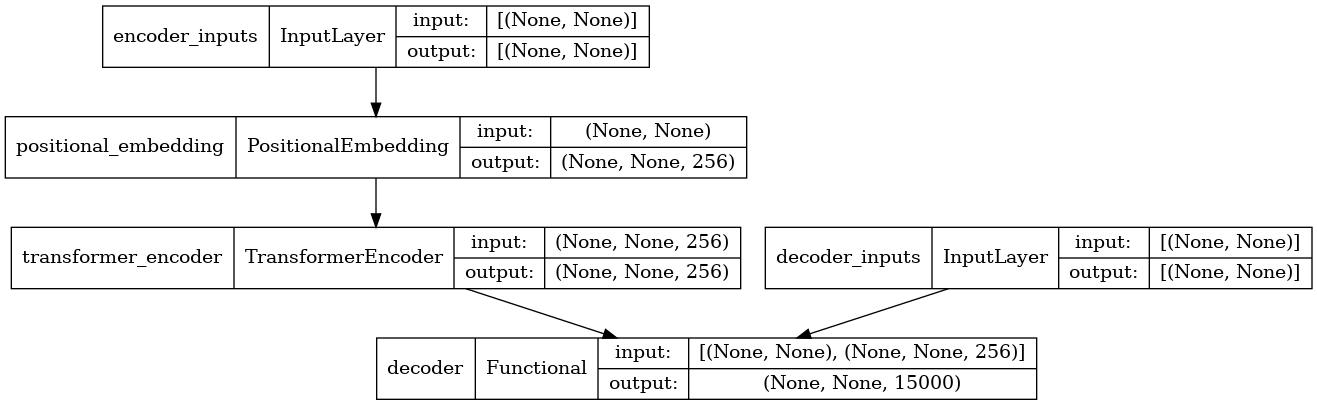

In [17]:
keras.utils.plot_model(transformer, show_shapes=True)

In [ ]:
if True:
    transformer.fit(train_ds, epochs=epochs, validation_data=val_ds)
else:
    transformer = keras.models.load_model('en-es-translator')

In [ ]:
transformer.save('en-de-translator');

## Decoding test sentences

Finally, let's demonstrate how to translate brand new English sentences.
We simply feed into the model the vectorized English sentence
as well as the target token `"[start]"`, then we repeatedly generated the next token, until
we hit the token `"[end]"`.

In [ ]:
deu_vocab = deu_vectorization.get_vocabulary()
deu_index_lookup = dict(zip(range(len(deu_vocab)), deu_vocab))
max_decoded_sentence_length = 20


def decode_sequence(input_sentence):
    
    tokenized_input_sentence = eng_vectorization([input_sentence]) # input_sequence = 'Tom put gas in the car.'
    decoded_sentence = "[start]"

    for i in range(max_decoded_sentence_length):
    
        tokenized_target_sentence = deu_vectorization([decoded_sentence])[:, :-1]
        predictions = transformer([tokenized_input_sentence, tokenized_target_sentence])

        sampled_token_index = np.argmax(predictions[0, i, :])
        sampled_token = deu_index_lookup[sampled_token_index]
        decoded_sentence += " " + sampled_token

        if sampled_token == "[end]":
            break
    
    return decoded_sentence

Lets translate 30 sentences from the test set. If you receive [UNK] means unknown word, token is not present in the vocabulary. Increase hidden states.

In [ ]:
# get english text from the test set
test_eng_texts = [pair[0] for pair in test_pairs]

for _ in range(10):
    
    # choose some text randomly
    input_sentence = random.choice(test_eng_texts)
    my_translation = decode_sequence(input_sentence)

    # use google translator
    google_translation = GoogleTranslator(source='en', target='de').translate(input_sentence) 

    print(  input_sentence, 
            '\n\tMine:',    my_translation.replace('[start]', '').replace('[end]', ''), 
            'Google:',  google_translation)